In [29]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
import copy
import calendar
#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [317]:
ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011.nc')
for year in range(2011, 2025):
    ds = xr.concat([ds, xr.open_dataset(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_{year}.nc')], dim='valid_time')

KeyboardInterrupt: 

In [8]:
#ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\90e456c5e1d922b3585912fb87eb01f1.nc')
ds.close()


In [ ]:
ds = ds.rename({'valid_time':'time'})

In [23]:
ds = ds.sortby('time')

In [24]:
d2m = ds['d2m'].resample(time="1D").mean()
t2m = ds['t2m'].resample(time="1D").mean()
ds_for_solrad = ds.where((ds['time.hour'] > 5)*(ds['time.hour'] < 19), drop=True)
ssrd = ds_for_solrad['ssrd'].resample(time="1D").mean()
tp = ds['tp'].resample(time="1D").sum()
ds_for_driver = xr.merge([d2m, t2m, ssrd, tp])
#ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
#ds_for_driver = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
ds_for_driver['t2m'] += -273.15
ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc')
#ds.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
#ds3 = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')

In [34]:
ds2 = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc')
ds2.close()
ds2 = ds2.rename({'latitude':'lat', 'longitude':'lon'})

In [36]:
ds2.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2011_2024.nc')

In [26]:
ds2

<xarray.Dataset> Size: 827MB
Dimensions:    (latitude: 91, longitude: 111, time: 5114)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 728B 56.0 55.9 55.8 55.7 ... 47.2 47.1 47.0
  * longitude  (longitude) float64 888B 5.0 5.1 5.2 5.3 ... 15.7 15.8 15.9 16.0
  * time       (time) datetime64[ns] 41kB 2011-01-01 2011-01-02 ... 2024-12-31
Data variables:
    d2m        (time, latitude, longitude) float32 207MB ...
    t2m        (time, latitude, longitude) float32 207MB ...
    ssrd       (time, latitude, longitude) float32 207MB ...
    tp         (time, latitude, longitude) float32 207MB ...
Attributes: (12/32)
    GRIB_paramId:                             168
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      10101
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre dewpoint temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

# Note to self about optimising:
 - Get values of development time at observation days;
 - Then scale GDD function so that development time is 1 at these days;
 - Use these as observations to optimise.

In [2]:
def RMSE_ML_model2(ds, phases, training_means):
    def RMSE(residuals):
        return np.sqrt(np.mean(residuals**2))
    for phase_index, phase in enumerate(phases):
        print('Phase: ' + str(phase))
        ML_residuals = ds[f'ML prediction emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        ML_residuals = ML_residuals.where(np.abs(ML_residuals) < 60)
        model_residuals = ds[f'modelled time emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        model_residuals = model_residuals.where(np.abs(model_residuals) < 60)
        residuals_to_average = training_means[phase_index] - ds[f'observed time emergence to {phase}']
        residuals_to_average = residuals_to_average.where(np.abs(model_residuals) < 60)
        print('RMSE for ML is ' + str(np.round(RMSE(ML_residuals), decimals=1)))
        print('RMSE for model is ' + str(np.round(RMSE(model_residuals), decimals=1)))
        print('RMSE to training mean is ' + str(np.round(RMSE(residuals_to_average), decimals=1)))

In [3]:
def RMSE_model2(ds, phases):
    def RMSE(residuals):
        return np.sqrt(np.mean(residuals**2))
    RMSEs = []
    for phase_index, phase in enumerate(phases):
        #print('Phase: ' + str(phase))
        model_residuals = ds[f'modelled time to {phase}'] - ds[f'observed time to {phase}']
        model_residuals = model_residuals.where(np.abs(model_residuals) < 60)
        #print('RMSE for model is ' + str(np.round(RMSE(model_residuals), decimals=1)))
        RMSEs.append(RMSE(model_residuals))
    return RMSEs

In [4]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    
    def __init__(self, address, raw = False):
        if raw:
            self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        else:
            self.phen_data = pd.read_csv(address)
        ## CONVERT DATE TO DATETIME ##
        self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
        self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
        self.phase_list = [] #list of phases to consider
        self.add_locations()
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            try:
                self.phen_data = self.phen_data.drop(drop_name, axis = 1)
            except:
                print(f'Column {drop_name} not found')
                continue
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = dataset_fctns.get_phase_name(phaseid, self.phase_names)
        self.order_phen_dataset()

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        self.phen_data = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #LAT, LON = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #self.phen_data['lat'] = LAT
        #self.phen_data['lon'] = LON
        #self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def index_time_from_emergence_day(self):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(366)])
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_driver_data = self.GDD_driver_data.sel(time=time_indexer, method='nearest')

    def align_emergence_obs_with_driver_data(self):
        ## Make sure we are comparing to observations where we have the driver data;
        #1. Align the times - need to check as it might run for some days then go off the end.
        #self.just_emergence = self.just_emergence.where(self.just_emergence['Referenzjahr'] <= 2024)
        ## Make sure all elements are in the driver data
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Eintrittsdatum'] + np.timedelta64(12, 'h'), self.GDD_driver_data['time'])]
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Stations_id'], self.GDD_driver_data['Stations_id'])]
        self.just_emergence = self.just_emergence.dropna()
    
    def get_unique_xy_station(self, x_coords, y_coords, station_ids):
        unique_values = np.unique(np.stack([x_coords, y_coords, station_ids]), axis = 1)
        return unique_values[0, :], unique_values[1, :], unique_values[2, :]

    def make_input_array(self, epsg_num = 3035, latlon_proj = False):
        self.latlon_proj = latlon_proj
        ## Puts pandas phenological frame into driver xarray and aligns the two
        #self.just_emergence = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        ## For now just do data after 2005 to save time
        self.obs_for_GDD = self.phen_data.where(self.phen_data['Eintrittsdatum'] >= np.datetime64('2011-01-01')).dropna()
        x_coords = self.obs_for_GDD['lon'].values
        y_coords = self.obs_for_GDD['lat'].values
        station_ids = np.int64(self.obs_for_GDD['Stations_id'].values)
        x_unique, y_unique, stations = self.get_unique_xy_station(x_coords, y_coords, station_ids)
        #Makes an array to put into GDD model
        print('project to new coords')
        if not(latlon_proj):
            x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_unique, y_unique, epsg_num = epsg_num)
            self.x_driver_proj = x_epsg
            self.y__driver_proj = y_epsg
        else:
            self.x_driver_proj = x_unique
            self.y__driver_proj = y_unique
        print('interpolate driver to station locations')
        # Working in xarray (not pandas) after this point:
        #print('Latlonproj:', not(latlon_proj))
        self.GDD_driver_data = dataset_fctns.interpolate_xy(self.x_driver_proj, self.y__driver_proj, self.T_mean, xy=not(latlon_proj))
        self.GDD_driver_data = self.GDD_driver_data.assign_coords(Stations_id=("modelpoint", stations))
        if not(latlon_proj):
            self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
        self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])

    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        self.obs_for_GDD = self.obs_for_GDD.where(self.obs_for_GDD['Referenzjahr'] <= 2023)
        ## Make the indexer to extract things at the right time.
        #self.align_emergence_obs_with_driver_data()
        self.obs_for_GDD = dataset_fctns.add_SOS_to_df(self.obs_for_GDD)
        self.obs_for_GDD['WC SOS date'] = pd.to_datetime(self.obs_for_GDD['Referenzjahr'], format='%Y') + pd.to_timedelta(self.obs_for_GDD['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.obs_for_GDD[['Stations_id', 'WC SOS date']])
        time_station = time_station.rename({'index':'Emergence observation', 'WC SOS date':'time'})
        if not(self.latlon_proj):
            time_station['time'] += np.timedelta64(12, 'h')
        ## Initiate development time storage object.
        t_dev = np.zeros(time_station.sizes['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        try:
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        except:
            print('Couldn\'t reset index for station')
        #Run model
        for day in range(300):
            #print(day)
            driver_values = self.GDD_driver_data.sel(time_station)[driver_variable].values 
            t_dev += response(driver_values, t_dev)
            dev_time_series.append(t_dev.copy())
            time_station['time'] += np.timedelta64(1, 'D')
        dev_time_series.append(self.obs_for_GDD['Eintrittsdatum'].values.astype('datetime64[Y]'))
        dev_time_series.append(self.obs_for_GDD['Stations_id'].values)
        self.model_dev_time_series = np.array(dev_time_series)
        self.GDD_driver_data['Development Time'] = (('days from emergence', 'Emergence observation'), self.model_dev_time_series)

    def get_phase_dates(self, thresholds):
        column_names = np.concatenate([np.array(thresholds), ['Referenzjahr'], ['Stations_id']])
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:-2, obs_index].astype(np.float64))
        self.phase_dates_array = np.concatenate([self.phase_dates_array, [pd.to_datetime(self.model_dev_time_series[-2]).year], [self.model_dev_time_series[-1]]], axis=0)
        self.phase_dates_array = pd.DataFrame(self.phase_dates_array.T, columns = column_names)
        self.phase_dates_array.set_index(['Referenzjahr', 'Stations_id'])
        self.phase_dates_calculated = True
        
        #Note that the thresholds are NOT the bins for numpy digitize!
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, winter_sowing = False, count_from_SOS = True):
        if count_from_SOS:
            self.phen_data = dataset_fctns.add_SOS_to_df(self.phen_data)
            self.phen_data['WC SOS date'] = pd.to_datetime(self.phen_data['Referenzjahr'], format='%Y') + pd.to_timedelta(self.phen_data['SOS'], 'D')
            self.ds_observed = self.phen_data[['Stations_id', 'Referenzjahr', 'lat', 'lon', 'WC SOS date']].drop_duplicates()
            for phase in self.phase_list:
                just_phase = self.phen_data.loc[self.phen_data['Name of phase'] == phase]
                just_phase= just_phase.assign(**{f'observed time to {phase}': just_phase['Eintrittsdatum'] - just_phase['WC SOS date']})
                self.ds_observed = self.ds_observed.merge(just_phase[[f'observed time to {phase}', 'Referenzjahr', 'Stations_id']], how = 'left', on = ['Referenzjahr', 'Stations_id'])
        else:
            observed_to_first_stage = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', self.phase_list[0], winter_sowing=winter_sowing).dropna()
            self.ds_observed = pd.DataFrame({f'observed time to {self.phase_list[0]}': observed_to_first_stage})
            for phase in self.phase_list[1:]:
                self.ds_observed[f'observed time to {phase}'] = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase, winter_sowing=winter_sowing).dropna()
            self.ds_observed = self.ds_observed.reset_index()
            self.ds_observed = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
            self.ds_observed = self.ds_observed.merge(self.obs_for_GDD[['Eintrittsdatum', 'Referenzjahr', 'Stations_id']], how = 'outer', on=['Referenzjahr', 'Stations_id']).rename(columns={'Eintrittsdatum':'emergence date'})
        #self.ds_observed = self.ds_observed.set_index(['Referenzjahr', 'Stations_id'])
        #self.ds_observed = pd.concat([self.just_emergence.set_index(['Referenzjahr', 'Stations_id'], inplace=False)['Eintrittsdatum'], self.ds_observed], axis=1).rename(columns={'Eintrittsdatum':'emergence date'})
        #LAT, LON = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        #self.ds_observed['lat'] = LAT
        #self.ds_observed['lon'] = LON
        #self.ds_observed['lat'] = self.ds_observed['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.ds_observed['lon'] = self.ds_observed['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.merge(self.ds_observed, self.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])

    def get_X_y_for_ML(self, driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2020, end_year = 2023):
        self.just_emergence = dataset_fctns.add_EOS_to_df(self.just_emergence)
        self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
        self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
        self.just_emergence['SOS'] = pd.to_timedelta(self.just_emergence['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'SOS']].drop_duplicates()) #, 'Referenzjahr'
        time_station = time_station.set_coords('Stations_id').set_xindex(['Stations_id'])
        time_station = time_station.drop_vars('index')
        time_station = time_station.expand_dims(dim={'time':pd.to_timedelta(np.arange(0, predictor_days), 'D')})
        time_station = time_station.expand_dims(dim={'Referenzjahr':pd.date_range(f'{start_year}-01-01', periods = end_year - start_year, freq='YS')})
        time_station['SOS'] = time_station['SOS'] + time_station['Referenzjahr'] + time_station['time'] 
        if not(self.latlon_proj):
            time_station['SOS'] += pd.Timedelta(12, 'h')
        time_station = time_station.rename({'time':'time_from_SOS', 'SOS':'time'})
        time_station = time_station.reset_index('Stations_id').reset_coords(names = 'Stations_id')
        self.time_station = time_station
        self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
        self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
        self.driver_data_for_ML = self.driver_data_for_ML.set_xindex(['Stations_id'])
        self.driver_data_for_ML['Referenzjahr'] = pd.to_datetime(self.driver_data_for_ML['Referenzjahr']).year
        self.driver_frame_for_ML = self.driver_data_for_ML.to_dataframe(dim_order = ['Referenzjahr', 'Stations_id', 'time_from_SOS'])
        self.driver_frame_for_ML = pd.concat([self.driver_frame_for_ML[driver_variable].unstack(),
                                            self.driver_frame_for_ML['lat'].unstack()['0 days'].rename('lat'),
                                            self.driver_frame_for_ML['lon'].unstack()['0 days'].rename('lon'),
                                            self.driver_frame_for_ML['time'].unstack()['0 days'].rename('WC SOS')], axis=1)
        self.driver_frame_for_ML.rename(columns={self.driver_frame_for_ML.columns[x]: f'{driver_variable} day {x}' for x in range(200)}, inplace=True)
        self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML.reset_index(), self.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)
        if self.phase_dates_calculated:
            self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML, self.phase_dates_array.reset_index(), how='left', on=['Referenzjahr', 'Stations_id'])

    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.GDD_driver_data['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, md=20):
        self.regr = tree.DecisionTreeRegressor(max_depth=md, min_samples_leaf=5)
        self.fit = self.regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(self.phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = self.fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = self.fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_predictions_training = self.ds_ML_predictions_training.drop_duplicates()
        self.ds_ML_predictions_verification = self.ds_ML_predictions_verification.drop_duplicates()
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results, self.ds_comparison, self.ds_observed], axis = 1)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_15432\2337456184.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [5]:
#Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt", raw = True)
Maize_set = Phenology_set('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv', raw = False)
Maize_set.drop_columns(['Unnamed: 9', 'Unnamed: 0'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])

Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2011_2024.nc') #C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array(latlon_proj=True)
Maize_set.phase_list = ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset()

Column Unnamed: 9 not found
project to new coords
interpolate driver to station locations


In [6]:
def put_temp_values_in_frame(driver_array, ds_observed, driver_variable, latlon_proj = True, phase_list = ['yellow ripeness']):
    
    observations_to_use = ds_observed[['Stations_id', 'Referenzjahr', 'WC SOS date']].where(ds_observed['Referenzjahr'] > 2010).dropna().drop_duplicates()
    # make an indexing array to pull values from the array of temperatures
    time_station = xr.Dataset.from_dataframe(observations_to_use)
    time_station = time_station.rename({'index':'observation', 'WC SOS date':'time'})
    #print(time_station)
    if not(latlon_proj):
        time_station['time'] += np.timedelta64(12, 'h')

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    try:
        driver_array = driver_array.set_xindex(['Stations_id'])
    except:
        print('Couldn\'t reset index for station')
    
    #Run model
    for day in range(300):
        # Pull values for temperature out of data frame
        driver_values = driver_array.sel(time_station[['Stations_id', 'time']])#[driver_variable]#.values 
        driver_frame_at_day = driver_values[[driver_variable, 'Stations_id', 'time']].to_pandas().reset_index().drop(['number', 'lon', 'lat', 'observation'], axis=1)
        driver_frame_at_day['Referenzjahr'] = driver_frame_at_day['time'].dt.year
        driver_frame_at_day = driver_frame_at_day.drop('time', axis=1)
        driver_frame_at_day = driver_frame_at_day.rename(columns = {driver_variable:f'temperature at day {day}'})
        observations_to_use = observations_to_use.merge(driver_frame_at_day, on=['Referenzjahr', 'Stations_id'])
        time_station['time'] += np.timedelta64(1, 'D')
    return observations_to_use.merge(ds_observed[['Referenzjahr', 'Stations_id'] + [f'observed time to {phase}' for phase in phase_list]]).drop_duplicates(subset = ['Referenzjahr', 'Stations_id'])


In [7]:
ds = put_temp_values_in_frame(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m')

Couldn't reset index for station


In [12]:
ds = ds.dropna(subset = ['temperature at day 0', 'observed time to yellow ripeness']).drop_duplicates()#['Referenzjahr'].min()
ds['WC SOS date'] = ds['WC SOS date'] +np.timedelta64(12, 'D')
ds = ds.where(ds['observed time to yellow ripeness'].dt.days > 0).dropna()

(array([   2.,    2.,   65.,  260.,  684., 1166.,  918.,  361.,   89.,
          21.]),
 array([ 81. ,  92.2, 103.4, 114.6, 125.8, 137. , 148.2, 159.4, 170.6,
        181.8, 193. ]),
 <BarContainer object of 10 artists>)

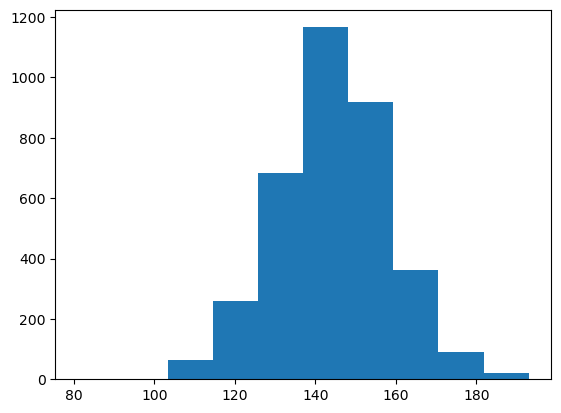

In [13]:
plt.hist(ds['observed time to yellow ripeness'].dt.days)

In [14]:
ds['observed time to yellow ripeness'].dt.days.std()

14.078826553334629

In [ ]:
constraints = scipy.optimize.LinearConstraint([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0], [0, 0, 0, -1, -1]], [0, 0, 0], [np.inf, np.inf, np.inf])
bounds = scipy.optimize.Bounds(lb=[0, 0, 20, 20, 35], ub = [100, 15, 50, 50, 60])
x_opt = scipy.optimize.differential_evolution(run_GDD_and_get_RMSE, bounds=bounds, constraints=constraints, args=(ds, 't2m'), maxiter = 10)
#x_opt = scipy.optimize.shgo(run_GDD_and_get_RMSE, bounds=bounds, constraints=constraints, args=(ds, 't2m'))
#x_opt = scipy.optimize.minimize(run_GDD_and_get_RMSE, x0 = [0.01, 8, 24, 30, 45], bounds=bounds, constraints=constraints, args=(ds, 't2m'), method='COBYLA', options = {'maxiter':100, 'catol': 0.01})

In [15]:
def run_GDD_and_get_RMSE(x, ds, driver_variable, latlon_proj = True):
    #resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 2, 28, 36), 
    #         lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36),
    #         lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36),
    #         lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
    thresholds = [10]
    phase_list = ['yellow ripeness']
    def response(meantemp):
        #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
        return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], x[3], x[4])

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(len(ds)) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    
    #Run model
    for day in range(300):
        # Pull values for temperature out of data frame
        driver_values = ds[f'temperature at day {day}']
        # Calculate the response for each of these temperatures and add it to the total accumulated temperature
        t_dev += response(driver_values)#, t_dev)
        #Store the accumulated temperature in an array
        dev_time_series.append(t_dev.copy())

    # Add the year and station codes for indexing later and to check that extracting values didn't mix up indexes
    dev_time_series.append(ds['Referenzjahr'].values)
    dev_time_series.append(ds['Stations_id'].values)
    #print([p.shape for p in dev_time_series])
    model_dev_time_series = np.array(dev_time_series)
    #driver_array['Development Time'] = (('days from emergence', 'Emergence observation'), model_dev_time_series)
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['Referenzjahr'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64))    
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names)
    comparison_array = ds.merge(phase_dates_array, how='left', on=['Referenzjahr', 'Stations_id']).dropna()
    def RMSE(residuals):
        return np.sqrt(np.mean(residuals**2))
    residuals = np.concatenate([(comparison_array[f'observed time to {phase}'].dt.days - comparison_array[f'modelled time to {phase}']).values for phase in phase_list])
    return RMSE(residuals)
    

In [16]:
def Trapezoid_Temp_derivs(T, T_min, T_opt1, T_opt2, T_max):
    pre_opt = ((T>=T_min)*(T<=T_opt1))*np.array([(T - T_min)/(T_opt1 - T_min),
                                               (T - T_opt1)/((T_opt1 - T_min)**2),
                                               (T_min - T)/((T_opt1 - T_min)**2),
                                               np.zeros(T.shape),
                                               np.zeros(T.shape)])
    opt = ((T>=T_opt1)*(T<=T_opt2))*np.array([np.ones(T.shape),
                                            np.zeros(T.shape),
                                            np.zeros(T.shape),
                                            np.zeros(T.shape),
                                            np.zeros(T.shape)])
    post_opt = ((T>=T_opt2)*(T<=T_max))*np.array([(T_max - T)/(T_max - T_opt2) ,
                                               np.zeros(T.shape),
                                               np.zeros(T.shape),
                                               (T_max - T)/((T_opt2 - T_max)**2),
                                               (T - T_opt2)/((T_opt2 - T_max)**2),])
    return pre_opt + opt + post_opt

In [17]:
def run_GDD_and_get_RMSE_derivs(x, ds, driver_variable, latlon_proj = True):
    #resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 2, 28, 36), 
    #         lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36),
    #         lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36),
    #         lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
    thresholds = [10]
    phase_list = ['yellow ripeness']
    def response(meantemp):
        #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
        return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], x[3], x[4])

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(len(ds)) #Continuous development time. When this passes through some thresholds then have change in phase.
    accumulated_deriv_time_series = [[t_dev.copy()] for count in range(len(x))]
    dev_time_series = [t_dev.copy()]
    
    #Run model
    for day in range(300):
        # Pull values for temperature out of data frame
        driver_values = ds[f'temperature at day {day}'].values
        # Calculate the response for each of these temperatures and add it to the total accumulated temperature
        response_deriv = x[0]*Trapezoid_Temp_derivs(driver_values, x[1], x[2], x[3], x[4])
        response_deriv[0, :] = response_deriv[0, :]/x[0]       
        for x_index in range(len(x)):
            accumulated_deriv_time_series[x_index].append(accumulated_deriv_time_series[x_index][-1] + response_deriv[x_index])
        t_dev += response(driver_values)#, t_dev)
        #print(len(accumulated_deriv_time_series[0][-1]))
        #print(accumulated_deriv_time_series[0][-1], t_dev/x[0])
        #Store the accumulated temperature in an array
        dev_time_series.append(t_dev.copy())

    # Add the year and station codes for indexing later and to check that extracting values didn't mix up indexes
    dev_time_series.append(ds['Referenzjahr'].values)
    dev_time_series.append(ds['Stations_id'].values)
    #print([p.shape for p in dev_time_series])
    model_dev_time_series = np.array(dev_time_series)
    #driver_array['Development Time'] = (('days from emergence', 'Emergence observation'), model_dev_time_series)
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['Referenzjahr'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64)) - 1
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names).astype('int64')
    for x_index in range(len(x)):
        accumulated_derivs = accumulated_deriv_time_series[x_index]
        accumulated_derivs.append(ds['Referenzjahr'].values)
        accumulated_derivs.append(ds['Stations_id'].values)
        #print(accumulated_derivs[300])
        for phase in phase_list:
            accumulated_derivs.append(np.array(accumulated_derivs).T[np.arange(len(ds)), phase_dates_array[f'modelled time to {phase}'].values])
        column_names = np.array(['Referenzjahr', 'Stations_id'] + [f'x{x_index} deriv for {phase}'])
        #print(np.array(accumulated_derivs[301]))
        if x_index == 0:
            derivs_array1 = pd.DataFrame(np.array(accumulated_derivs[301:]).T, columns = column_names)
            derivs_array = pd.DataFrame(np.array(accumulated_derivs[301:]).T, columns = column_names)
            #print(derivs_array.shape)
        else:
            derivs_array2 = pd.DataFrame(np.array(accumulated_derivs[301:]).T, columns = column_names)
            derivs_array = derivs_array.merge(derivs_array2, how='left', on=['Referenzjahr', 'Stations_id'])
            #print(derivs_array.shape)
    comparison_array = ds.merge(phase_dates_array, how='left', on=['Referenzjahr', 'Stations_id']).dropna()
    comparison_array = comparison_array.merge(derivs_array, on=['Referenzjahr', 'Stations_id'])
    def RMSE(residuals):
        return np.sqrt(np.mean(residuals**2))
    residuals = np.concatenate([(comparison_array[f'observed time to {phase}'].dt.days - comparison_array[f'modelled time to {phase}']).values for phase in phase_list])
    error = RMSE(residuals)
    #print(len(residuals), len(comparison_array))
    #print(residuals)
    deriv_list = [
        -((comparison_array['modelled time to yellow ripeness'] - comparison_array['observed time to yellow ripeness'].dt.days)*
         comparison_array[f'x{xindex} deriv for yellow ripeness']/x[0]).mean()/error for xindex in range(len(x))
         #(comparison_array['modelled time to yellow ripeness']/(1 + comparison_array[f'x{xindex} deriv for yellow ripeness']) - comparison_array['modelled time to yellow ripeness'])).sum() for xindex in range(len(x))
    ]
    return deriv_list#, comparison_array, phase_dates_array, derivs_array, derivs_array2, derivs_array1
    

In [20]:
x0 = np.array([0.125, 6, 28, 32, 45])
for count in range(3):
    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x, x0[1], x0[2], x0[3], x0[4]], ds, 't2m'),
                                        bounds = (0.05, 0.5),
                                        method='bounded',
                                        options = {'disp': 2})
    x0 = np.array([x_0.x, x0[1], x0[2], x0[3], x0[4]])
    print(x0)
    x_1 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x0[0], x, x0[2], x0[3], x0[4]], ds, 't2m'),
                                        bounds = (0, min(x0[2], 20)),
                                        method='bounded',
                                        options = {'disp': 2})
    x0 = [x0[0], x_1.x, x0[2], x0[3], x0[4]]
    print(x0)
    x_2 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x0[0], x0[1], x, x0[3], x0[4]], ds, 't2m'),
                                        bounds = (max(x0[1], 12), min(x0[3], 40)),
                                        method='bounded',
                                        options = {'disp': 2})
    x0 = [x0[0], x0[1], x_2.x, x0[3], x0[4]]
    print(x0)
    x_3 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x0[0], x0[1], x0[2], x, x0[4]], ds, 't2m'),
                                        bounds = (max(x0[2], 30), min(x0[4], 50)),
                                        method='bounded',
                                        options = {'disp': 2})
    x0 = [x0[0], x0[1], x0[2], x_3.x, x0[4]]
    print(x0)
    x_4 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x0[0], x0[1], x0[2], x, x0[4]], ds, 't2m'),
                                        bounds = (max(x0[3], 30), 50),
                                        method='bounded',
                                        options = {'disp': 2})
    x0 = [x0[0], x0[1], x0[2], x0[3], x_4.x]
    print(x0)



Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )
[ 0.15625543  6.         28.         32.         45.        ]

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )
[0.15625542855494493, 5.834975229387588, 28.0, 32.0, 45.0]

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )
[0.15625542855494493, 5.834975229387588, 28.0053481739408, 32.0, 45.0]

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )
[0.15625542855494493, 5.834975229387588, 28.0053481739408, 44.999995938433585, 45.0]

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )
[0.15625542855494493, 5.834975229387588, 28.0053481739408, 44.999995938433585, 49.999992964152305]

Optimization terminated successfully;
The r

In [26]:
ds['observed time to yellow ripeness'].dt.days.std()

24.077964220831255

In [22]:
x0 = np.array([0.125, 6, 28, 32, 45])
x0 = res.x
x0a, x1a, x2a, x3a, x4a = (0.05, 1, 1, 1, 1)
x0b, x1b, x2b, x3b, x4b = (0, -1, -1, -1, -1)
for x1 in [x0 + np.array([x0a, x1a, x2a, x3a, x4a]),
           x0 + np.array([x0b, x1a, x2a, x3a, x4a]),
           x0 + np.array([x0a, x1b, x2a, x3a, x4a]),
           x0 + np.array([x0b, x1b, x2a, x3a, x4a]),
           x0 + np.array([x0a, x1a, x2b, x3a, x4a]),
           x0 + np.array([x0b, x1a, x2b, x3a, x4a]),
           x0 + np.array([x0a, x1b, x2b, x3a, x4a]),
           x0 + np.array([x0b, x1b, x2b, x3a, x4a]),
           x0 + np.array([x0a, x1a, x2a, x3b, x4a]),
           x0 + np.array([x0b, x1a, x2a, x3b, x4a]),
           x0 + np.array([x0a, x1b, x2a, x3b, x4a]),
           x0 + np.array([x0b, x1b, x2a, x3b, x4a]),
           x0 + np.array([x0a, x1a, x2b, x3b, x4a]),
           x0 + np.array([x0b, x1a, x2b, x3b, x4a]),
           x0 + np.array([x0a, x1b, x2b, x3b, x4a]),
           x0 + np.array([x0b, x1b, x2b, x3b, x4a])]:
    print(run_GDD_and_get_RMSE(x1, ds, 't2m'))

30.547131488119575
21.960765565326874
36.60720098118853
11.645682334683475
36.98961343731713
12.234615579806757
42.42457366518426
13.849112823894844
30.547131488119575
21.960765565326874
36.60720098118853
11.645682334683475
36.98961343731713
12.234615579806757
42.42457366518426
13.849112823894844


In [50]:
xmins = np.array([2, 20, 20, 35])
dists = np.array([12, 40, 40, 60]) - xmins
np.random.seed(10)
hcube = scipy.stats.qmc.LatinHypercube(4)
samples = hcube.random(n=10)
print(samples[1, :])
print(samples[1, :]*dists)
for sample_index in range(samples.shape[0]):
    x0 = xmins + samples[sample_index, :]*dists
    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x, x0[0], x0[1], x0[2], x0[3]], ds, 't2m'),
                                        bounds = (0.05, 0.5),
                                        method='bounded',
                                        options = {'disp': 3})
    x1 = np.array([x_0.x, x0[0], x0[1], x0[2], x0[3]])
    print(run_GDD_and_get_RMSE(x1, ds, 't2m'))
    

[0.23143393 0.12733037 0.50969297 0.64873192]
[ 2.31433933  2.54660743 10.1938593  16.21829793]
 
 Func-count     x          f(x)          Procedure
    1       0.221885      153.509        initial
    2       0.328115      90.8424        golden
    3       0.393769      50.4638        golden
    4       0.434346      36.4468        golden
    5       0.482123      35.6118        parabolic
    6       0.463874      35.3701        golden
    7       0.466633      35.6294        parabolic
    8       0.452595      35.0916        golden
    9       0.445624      35.5876        golden
   10       0.455883       35.077        parabolic
   11        0.45485      35.1195        parabolic
   12       0.458935      35.2054        golden
   13       0.457049      35.1928        golden
   14       0.456329      35.1245        golden
   15       0.455489      35.0667        golden
   16       0.455245      35.1172        golden
   17        0.45564      35.0556        golden
   18       0.455654  

In [28]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ds, test_size=0.5)
ineq_cons = {'type': 'ineq',
             'fun' : lambda x: np.array([x[2] - x[1],
                                         x[3] - x[2],
                                         x[4] - x[3]]),
             'jac' : lambda x: np.array([[0, -1, 1, 0, 0],
                                         [0, 0, -1, 1, 0],
                                         [0, 0, 0, -1, 1]])}
constraints = scipy.optimize.LinearConstraint([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0], [0, 0, 0, -1, -1]], [0, 0, 0], [np.inf, np.inf, np.inf])
bounds = scipy.optimize.Bounds(lb=[0.05, 2, 20, 20, 35], ub = [1, 12, 40, 40, 60])
x0 = np.array([1, 4, 25, 35, 45])
for x0 in [np.array([0.175, 7, 29, 33, 46]), np.array([0.1, 4, 25, 35, 45]), np.array([0.15, 6, 20, 22, 30])]:#, np.array([1, 1, 30, 31, 45]), np.array([1, 4, 20, 22, 25]), np.array([1, 4, 35, 37, 45])]:
    res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train.drop_duplicates(), 't2m'), 
                              x0, method='SLSQP', #'trust-constr',#
                              jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train.drop_duplicates(), 't2m'),#jac='3-point',#
                              constraints=[ineq_cons],#[constraints], #
                              options={'ftol': 1e-9, 'disp': True, 'eps': 0.001},#{'verbose': 2, 'maxiter':500},#
                              bounds=bounds)
    print(res.x)
    print(run_GDD_and_get_RMSE(res.x, test, 't2m'))
    print(1 - (run_GDD_and_get_RMSE(res.x, test, 't2m')**2/(test['observed time to yellow ripeness'].dt.days.var())))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.751442998885448
            Iterations: 13
            Function evaluations: 39
            Gradient evaluations: 13
[ 0.12437688  2.         28.10070864 33.         46.        ]
11.624376158583013
0.3092220762925607
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21.547918235158086
            Iterations: 13
            Function evaluations: 47
            Gradient evaluations: 13
[ 0.21985873  8.2398199  31.31256733 35.7667785  45.        ]
23.698403949966433
-1.8710273881358033
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.402762036576062
            Iterations: 18
            Function evaluations: 37
            Gradient evaluations: 18
[ 0.10158373  2.         22.81722015 22.81722015 35.31374472]
11.25011210706474
0.3529872484609955


In [29]:
c_array = run_GDD_and_get_RMSE_derivs(res.x,ds.drop_duplicates(), 't2m')

In [21]:
print(run_GDD_and_get_RMSE(res.x, ds, 't2m')**2/ds['observed time to yellow ripeness'].dt.days.var())

0.6989399689399907


In [27]:
x0 = np.array([11.36, 5.757, 22.68, 25.17, 45])
x0 = np.array([11.36, 5.757, 22.68, 35, 45])
grad_algebraic = run_GDD_and_get_RMSE_derivs(x0, ds.drop_duplicates(), 't2m')
for h in [0.00005, 0.0001, 0.001, 0.01, 0.1]:
    grads_numeric0 = []
    grads_numeric1 = []
    grads_numeric2 = []
    for x_index in range(len(x0)):
        x_plus_h = x0
        x_minus_h =  x0
        h_perturb = [0 for count in range(len(x0))]
        h_perturb[x_index] = h
        h_perturb = np.array(h_perturb)
        x_plus_h = x_plus_h + h_perturb
        x_minus_h = x_minus_h - h_perturb
        #print(x_minus_h, x_plus_h)
        grad_numeric = (run_GDD_and_get_RMSE(x_plus_h, ds.drop_duplicates(), 't2m') - run_GDD_and_get_RMSE(x_minus_h, ds.drop_duplicates(), 't2m'))/(2*h)
        grads_numeric0.append(grad_numeric)
        grad_numeric = (run_GDD_and_get_RMSE(x_plus_h, ds.drop_duplicates(), 't2m') - run_GDD_and_get_RMSE(x0, ds.drop_duplicates(), 't2m'))/h
        grads_numeric1.append(grad_numeric)
        grad_numeric = (run_GDD_and_get_RMSE(x0, ds.drop_duplicates(), 't2m') - run_GDD_and_get_RMSE(x_minus_h, ds.drop_duplicates(), 't2m'))/h
        grads_numeric2.append(grad_numeric)
    
    print(grads_numeric0, grads_numeric1, grads_numeric2, grad_algebraic)

[0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0] [0.06236751439352435, -0.18806518355528384, -0.04186580177926116, -0.0, -0.0]
[0.0, -1.393704267229623, 0.0, 0.0, 0.0] [0.0, -2.787408534459246, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0] [0.06236751439352435, -0.18806518355528384, -0.04186580177926116, -0.0, -0.0]
[0.2857340525537211, -2.244927639239336, -0.2857340525537211, 0.0, 0.0] [0.2927272516615176, -3.3029649596016952, -0.2787408534459246, 0.0, 0.0] [0.2787408534459246, -1.1868903188769764, -0.2927272516615176, 0.0, 0.0] [0.06236751439352435, -0.18806518355528384, -0.04186580177926116, -0.0, -0.0]
[0.7264846405377057, -1.189216418154615, -0.4429919223511547, 0.0, 0.0] [0.5191072243377448, -1.462115696384103, -0.5759758083229372, 0.0, 0.0] [0.9338620567376665, -0.9163171399251269, -0.31000803637937224, 0.0, 0.0] [0.06236751439352435, -0.18806518355528384, -0.04186580177926116, -0.0, -0.0]
[0.3592083526676504, -1.1207024027120838, -0.2538197273459275, 0.0

In [295]:
c_array = run_GDD_and_get_RMSE_derivs([7, 4, 12, 25, 45],ds.drop_duplicates(), 't2m')
#c_array = run_GDD_and_get_RMSE_derivs([1.136e+00, 5.757e+00, 2.268e+01, 2.517e+01, 4.500e+01],ds.drop_duplicates(), 't2m')

In [296]:
c_array#2.drop_duplicates()

[1.933311846964822, -0.578554352201605, -0.9637778732950953, -0.0, -0.0]

In [200]:
d3 = d_array2.merge(d_array1, on=['Referenzjahr', 'Stations_id'], how='left')#.where(d_array2['Referenzjahr'] != d_array1['Referenzjahr']).dropna()#

MergeError: Merge keys are not unique in either left or right dataset; not a one-to-one merge

In [203]:
ds[['Stations_id', 'Referenzjahr']].drop_duplicates()#merge(d_array1, on=['Referenzjahr', 'Stations_id'], )#.where(d3['Referenzjahr'] != d_array1['Referenzjahr']).dropna()#

,Stations_id,Referenzjahr
0,7521.0,2022.0
1,7521.0,2023.0
2,7532.0,2022.0
3,7532.0,2023.0
4,7592.0,2022.0
...,...,...
5779,19755.0,2016.0
5781,19914.0,2015.0
5782,19914.0,2016.0
5784,19914.0,2018.0


In [190]:
d_array1

,Referenzjahr,Stations_id,x0 deriv for yellow ripeness
0,2022.0,7521.0,142.482069
1,2023.0,7521.0,141.917387
2,2022.0,7532.0,NaN
3,2023.0,7532.0,NaN
4,2022.0,7592.0,142.505766
...,...,...,...
5742,2015.0,19914.0,142.400689
5743,2016.0,19914.0,142.341654
5744,2016.0,19914.0,142.341654
5745,2018.0,19914.0,142.265254


In [175]:
ds#.drop_duplicates()['Referenzjahr'].min()

,Stations_id,Referenzjahr,WC SOS date,temperature at day 0,temperature at day 1,temperature at day 2,temperature at day 3,temperature at day 4,temperature at day 5,temperature at day 6,...,temperature at day 291,temperature at day 292,temperature at day 293,temperature at day 294,temperature at day 295,temperature at day 296,temperature at day 297,temperature at day 298,temperature at day 299,observed time to yellow ripeness
0,7521.0,2022.0,2022-04-15,7.686438,6.487622,7.209476,8.240496,7.844360,8.977308,8.272851,...,2.045750,4.094359,4.681995,5.660029,5.523886,3.952371,5.199250,3.913649,7.095561,145 days
1,7521.0,2023.0,2023-04-15,8.601258,8.967707,7.937264,7.560472,8.607448,8.463228,9.939761,...,4.604246,4.794141,4.488494,6.495872,0.826783,0.801475,0.486825,-0.545688,-0.382520,167 days
2,7532.0,2022.0,2022-04-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153 days
3,7532.0,2023.0,2023-04-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149 days
4,7592.0,2022.0,2022-04-15,8.044737,7.021751,7.811838,9.119407,8.509791,8.572464,9.260391,...,1.822730,3.267355,4.615325,5.328165,5.966853,3.676649,5.504175,3.767278,6.845227,146 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5781,19914.0,2015.0,2015-04-16,13.670408,8.748350,6.475231,7.480706,9.502203,11.293906,7.882478,...,-1.254717,-0.990492,-1.936311,-3.881007,-4.495921,-3.216758,-3.658665,-0.656749,0.741819,NaT
5782,19914.0,2016.0,2016-04-15,10.137053,9.878025,7.684272,6.649688,7.347442,7.427813,9.451701,...,8.939118,8.364475,3.273022,1.515674,3.458552,6.186936,5.631906,5.421967,5.570038,NaT
5783,19914.0,2016.0,2016-04-15,10.137053,9.878025,7.684272,6.649688,7.347442,7.427813,9.451701,...,8.939118,8.364475,3.273022,1.515674,3.458552,6.186936,5.631906,5.421967,5.570038,NaT
5784,19914.0,2018.0,2018-04-16,13.754462,14.519780,15.272054,15.969455,17.007817,17.297339,18.036018,...,2.254564,0.263443,0.381115,-1.332399,-2.011476,-2.498212,-2.555342,-2.595474,-1.757666,NaT


In [163]:
p_array#.drop_duplicates()['Referenzjahr'].min()

,modelled time to yellow ripeness,Referenzjahr,Stations_id
0,152,2022,7521
1,153,2023,7521
2,300,2022,7532
3,300,2023,7532
4,150,2022,7592
...,...,...,...
5742,150,2015,19914
5743,156,2016,19914
5744,156,2016,19914
5745,144,2018,19914


In [147]:
c_array2

,Stations_id,Referenzjahr,WC SOS date,temperature at day 0,temperature at day 1,temperature at day 2,temperature at day 3,temperature at day 4,temperature at day 5,temperature at day 6,...,temperature at day 297,temperature at day 298,temperature at day 299,observed time to yellow ripeness,modelled time to yellow ripeness,x0 deriv for yellow ripeness,x1 deriv for yellow ripeness,x2 deriv for yellow ripeness,x3 deriv for yellow ripeness,x4 deriv for yellow ripeness
0,7521.0,2022.0,2022-04-15,7.686438,6.487622,7.209476,8.240496,7.844360,8.977308,8.272851,...,5.199250,3.913649,7.095561,145 days,152,142.482069,-8.315055,-17.934945,0.344746,0.005254
1,7521.0,2023.0,2023-04-15,8.601258,8.967707,7.937264,7.560472,8.607448,8.463228,9.939761,...,0.486825,-0.545688,-0.382520,167 days,153,141.917387,-9.697287,-13.927713,0.000000,0.000000
2,7592.0,2022.0,2022-04-15,8.044737,7.021751,7.811838,9.119407,8.509791,8.572464,9.260391,...,5.504175,3.767278,6.845227,146 days,150,142.505766,-6.350619,-17.274381,0.967266,0.082734
3,7623.0,2022.0,2022-04-14,9.197465,8.016951,7.164073,7.520632,8.850772,8.503426,9.292245,...,4.396516,5.222656,4.305705,149 days,152,141.872349,-8.861695,-21.763305,0.000000,0.000000
4,7623.0,2023.0,2023-04-14,7.515055,9.005970,9.305843,8.339424,7.879200,8.471385,8.743051,...,1.555830,2.083176,0.236003,151 days,155,142.737879,-10.729356,-17.270644,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105590,19755.0,2016.0,2016-04-17,7.903358,6.331197,7.681076,6.868287,8.529396,7.337019,5.521364,...,6.166785,2.831129,2.613566,173 days,155,141.942090,-8.791252,-9.583748,0.346232,0.003768
105591,19755.0,2016.0,2016-04-17,7.903358,6.331197,7.681076,6.868287,8.529396,7.337019,5.521364,...,6.166785,2.831129,2.613566,173 days,155,141.942090,-8.791252,-9.583748,0.346232,0.003768
105592,19755.0,2016.0,2016-04-17,7.903358,6.331197,7.681076,6.868287,8.529396,7.337019,5.521364,...,6.166785,2.831129,2.613566,173 days,155,141.942090,-8.791252,-9.583748,0.346232,0.003768
105593,19755.0,2016.0,2016-04-17,7.903358,6.331197,7.681076,6.868287,8.529396,7.337019,5.521364,...,6.166785,2.831129,2.613566,173 days,155,141.942090,-8.791252,-9.583748,0.346232,0.003768


In [251]:
T_min_values = np.arange(0, 7, 0.5)
T_opt1_values = np.arange(15, 23, 0.5)
T_mins, T_opt1s = np.meshgrid(T_min_values, T_opt1_values)
RMSEs = np.zeros(T_mins.shape)
for i in range(T_mins.shape[0]):
    print(T_opt1_values[i])
    for j in range(T_mins.shape[1]):
        RMSEs[i, j] = run_GDD_and_get_RMSE(np.array([10, T_mins[i, j], T_opt1s[i, j], 35, 45]), ds, 't2m')

15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5
20.0
20.5
21.0
21.5
22.0
22.5


In [73]:
scale_values = np.arange(0.7, 1.3, 0.05)
T_opt1_values = np.arange(15, 25, 0.5)
scales, T_opt1s = np.meshgrid(scale_values, T_opt1_values)
RMSE2s = np.zeros(T_opt1s.shape)
for i in range(T_opt1s.shape[0]):
    print(T_opt1_values[i])
    for j in range(T_opt1s.shape[1]):
        RMSE2s[i, j] = run_GDD_and_get_RMSE(np.array([scales[i, j], 0, T_opt1s[i, j], 35, 45]), ds, 't2m')

15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5
20.0
20.5
21.0
21.5
22.0
22.5
23.0
23.5
24.0
24.5


In [271]:
scale_values = np.arange(9.7, 10.3, 0.05)
T_opt1_values = np.arange(23, 24, 0.05)
scales, T_opt1s = np.meshgrid(scale_values, T_opt1_values)
RMSE2s = np.zeros(T_opt1s.shape)
for i in range(T_opt1s.shape[0]):
    print(T_opt1_values[i])
    for j in range(T_opt1s.shape[1]):
        RMSE2s[i, j] = run_GDD_and_get_RMSE(np.array([scales[i, j], 0, T_opt1s[i, j], 35, 45]), ds, 't2m')

23.0
23.05
23.1
23.150000000000002
23.200000000000003
23.250000000000004
23.300000000000004
23.350000000000005
23.400000000000006
23.450000000000006
23.500000000000007
23.550000000000008
23.60000000000001
23.65000000000001
23.70000000000001
23.75000000000001
23.80000000000001
23.850000000000012
23.900000000000013
23.950000000000014


In [273]:
derivs

[-0.42746413838370567, 0.04762056702824418, 0.15064855742677266, -0.0, -0.0]

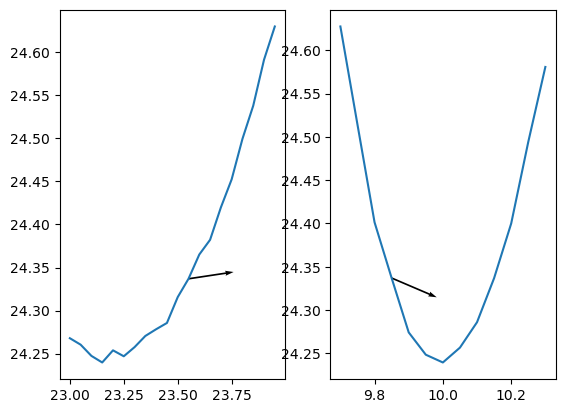

In [272]:
fig, ax = plt.subplots(1, 2)
scaleindex = 3
Toptindex = 11
scale_values = np.arange(9.7, 10.3, 0.05)
T_opt1_values = np.arange(23, 24, 0.05)
scales, T_opt1s = np.meshgrid(scale_values, T_opt1_values)
derivs = run_GDD_and_get_RMSE_derivs(np.array([scales[Toptindex, scaleindex], 0, T_opt1s[Toptindex, scaleindex], 35, 45]), ds, 't2m')
ax[0].plot(T_opt1s[:, scaleindex], RMSE2s[:, scaleindex], )
ax[0].quiver(T_opt1s[Toptindex, scaleindex], RMSE2s[Toptindex, scaleindex], 1, derivs[2], scale = 5)
ax[1].plot(scales[Toptindex, :], RMSE2s[Toptindex, :], )
ax[1].quiver(scales[Toptindex, scaleindex], RMSE2s[Toptindex, scaleindex], 1, derivs[0], scale = 5)

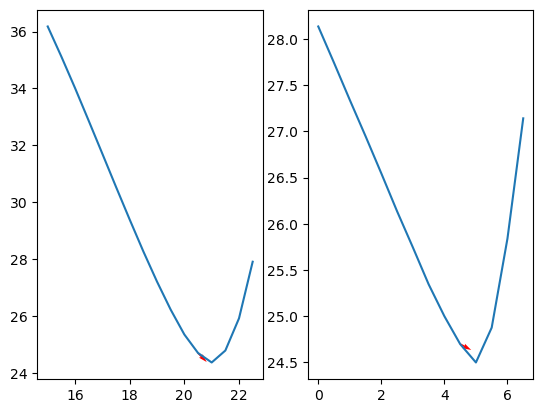

In [260]:
T_min_values = np.arange(0, 7, 0.5)
T_opt1_values = np.arange(15, 23, 0.5)
T_mins, T_opt1s = np.meshgrid(T_min_values, T_opt1_values)
fig, ax = plt.subplots(1, 2)
Tminindex = 11
Toptindex = 9
derivs = run_GDD_and_get_RMSE_derivs(np.array([10, T_mins[Tminindex, Toptindex], T_opt1s[Tminindex, Toptindex], 35, 45]), ds, 't2m')
ax[0].plot(T_opt1s[:, Toptindex], RMSEs[:, Toptindex], )
ax[0].quiver(T_opt1s[Tminindex, Toptindex], RMSEs[Tminindex, Toptindex], 5, 5*derivs[2], color='red')
ax[1].plot(T_mins[Tminindex, :], RMSEs[Tminindex, :], )
ax[1].quiver(T_mins[Tminindex, Toptindex], RMSEs[Tminindex, Toptindex], 5, 5*derivs[1], color='red')

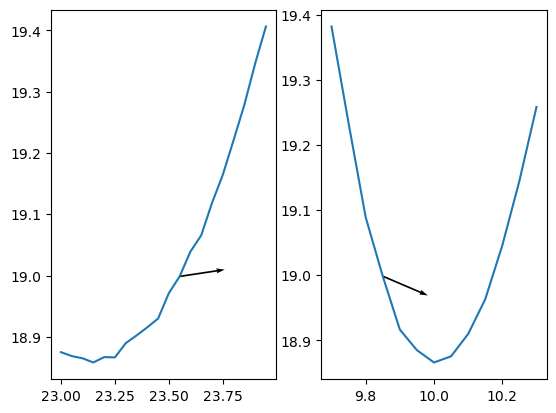

18.85502652987415 T_opt1 = 23.950000000000014 scale = 10.300000000000008


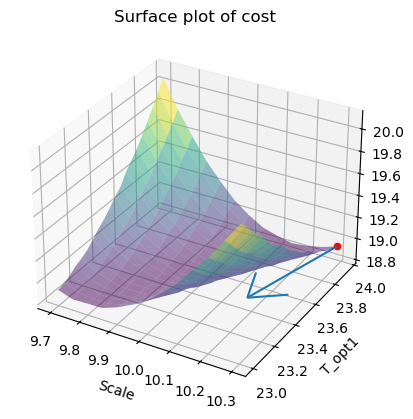

In [230]:
fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection='3d')
 
# syntax for plotting
ax.plot_surface(scales, T_opt1s, RMSE2s, cmap='viridis', alpha = 0.5)
ax.set(xlabel = 'Scale')
ax.set(ylabel = 'T_opt1')
ax.set_title('Surface plot of cost')
mindex = np.unravel_index(np.argmin(RMSE2s), T_opt1s.shape)
mindex = (-1, -1)
ax.scatter(scales[mindex], T_opt1s[mindex], RMSE2s[mindex], color = 'red', s=20)
print(RMSE2s.min(), f'T_opt1 = {T_opt1s[mindex]}', f'scale = {scales[mindex]}')


# Make the direction data for the arrows
derivs = run_GDD_and_get_RMSE_derivs(np.array([scales[mindex], 0, T_opt1s[mindex], 35, 45]), ds, 't2m')

ax.quiver(scales[mindex], T_opt1s[mindex], RMSE2s[mindex], -derivs[0], -derivs[2], -3, length=1, normalize=True)

18.85502652987415 T_opt1 = 23.450000000000006 scale = 9.950000000000003


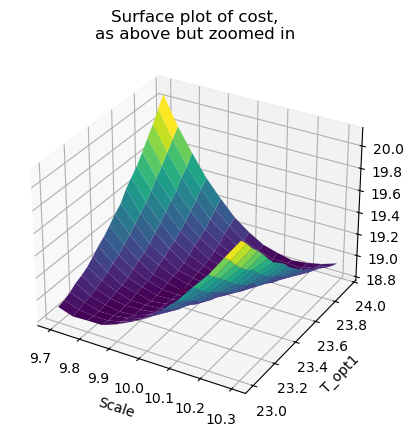

In [95]:
fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection='3d')
 
# syntax for plotting
ax.plot_surface(scales, T_opt1s, RMSE2s, cmap='viridis')
ax.set(xlabel = 'Scale')
ax.set(ylabel = 'T_opt1')
ax.set_title('Surface plot of cost,\nas above but zoomed in')
mindex = np.unravel_index(np.argmin(RMSE2s), T_opt1s.shape)
ax.scatter(scales[mindex], T_opt1s[mindex], RMSE2s[mindex], color = 'red')
print(RMSE2s.min(), f'T_opt1 = {T_opt1s[mindex]}', f'scale = {scales[mindex]}')

In [57]:
ds['Referenzjahr'].min()

2019.0

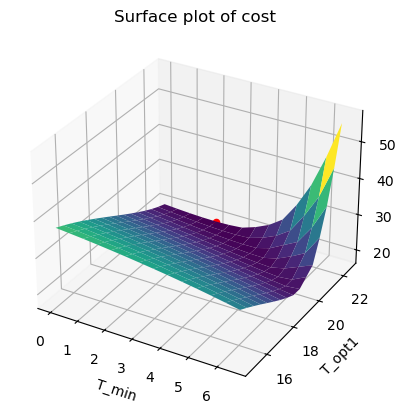

In [86]:
fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection='3d')
 
# syntax for plotting
ax.plot_surface(T_mins, T_opt1s, RMSEs, cmap='viridis')
ax.set(xlabel = 'T_min', ylabel = 'T_opt1')
ax.set_title('Surface plot of cost')
mindex = np.unravel_index(np.argmin(RMSEs), T_mins.shape)
ax.scatter(T_mins[mindex], T_opt1s[mindex], RMSEs[mindex], color = 'red')
print(RMSEs.min(), f'T_opt1 = {T_opt1s[mindex]}', f'T_min = {T_mins[mindex]}')

In [54]:
mindex = np.unravel_index(np.argmin(RMSEs), T_mins.shape)
print(mindex)
print(T_mins[np.argmin(RMSEs, keepdims=True)])

(44, 0)


IndexError: index 2200 is out of bounds for axis 0 with size 50

In [45]:
T_mins.shape

(50, 50)

In [28]:
c_array

[15.229994929368502,
 -0.3062788368843089,
 -0.7798407794794937,
 0.0687012132209716,
 0.005682433334516543]

In [ ]:
ineq_cons = {'type': 'ineq',
             'fun' : lambda x: np.array([x[1] - 0, 
                                         10 - x[1], 
                                         x[2] - 10,
                                         25 - x[2],
                                         x[3] - 20,
                                         35 - x[3],
                                         x[4] - 35,
                                         50 - x[4],
                                         x[2] - x[1],
                                         x[3] - x[2],
                                         x[4] - x[3]]),
             'jac' : lambda x: np.array([[0, 1, 0, 0, 0],
                                         [0, -1, 0, 0, 0],
                                         [0, 0, 1, 0, 0],
                                         [0, 0, -1, 0, 0],
                                         [0, 0, 0, 1, 0],
                                         [0, 0, 0, -1, 0],
                                         [0, 0, 0, 0, 1],
                                         [0, 0, 0, 0, -1],
                                         [0, -1, 1, 0, 0],
                                         [0, 0, -1, 1, 0],
                                         [0, 0, 0, -1, 1]])}

In [293]:

#x_opt = scipy.optimize.shgo(lambda x: run_GDD_and_get_RMSE(x, ds, 't2m'), 
#                            bounds=bounds, constraints=constraints, iters=10, sampling_method='simplicial',
#                            minimizer_kwargs={'method':'SLSQP',
#                                              'jac': lambda x: run_GDD_and_get_RMSE_derivs(x, ds, 't2m')}
#                            )

Optimization terminated successfully    (Exit mode 0)
            Current function value: 24.383317850047465
            Iterations: 6
            Function evaluations: 89
            Gradient evaluations: 6
[1.16143056e+00 6.51127978e-03 2.69762720e+01 3.50000000e+01
 4.50000000e+01]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 25.473506592266318
            Iterations: 2
            Function evaluations: 32
            Gradient evaluations: 2
[ 1.06575324  6.         20.         22.         35.        ]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 24.259566337662655
            Iterations: 5
            Function evaluations: 63
            Gradient evaluations: 5
[ 1.42916318  1.         32.47872763 32.47872763 45.        ]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 24.45390472920437
            Iterations: 7
            Function evaluations: 103
  

In [54]:
ds.drop_duplicates()['observed time to yellow ripeness'].dt.days.std()

11.912992844285023

In [62]:
x1 = res.x

In [67]:
Trapezoid_Temp_derivs(np.array([15, 30, 40]), 8, 28, 36, 45)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 10.7659466938514
       x: [ 1.100e+00  5.479e-17  2.627e+01  3.500e+01  4.500e+01]
     nit: 14
     jac: [-4.574e-01  8.309e-02  3.946e-02 -0.000e+00 -0.000e+00]
    nfev: 43
    njev: 14

In [ ]:
def run_GDD_and_get_RMSE(x, driver_array, ds_observed, driver_variable, latlon_proj = True):
    #resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 2, 28, 36), 
    #         lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36),
    #         lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36),
    #         lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
    thresholds = [1]
    phase_list = ['yellow ripeness']
    def response(meantemp):
        #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
        return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], x[3], x[4])
    
    observations_to_use = ds_observed[['Stations_id', 'Referenzjahr', 'WC SOS date']].where(ds_observed['Referenzjahr'] > 2017).dropna().drop_duplicates()
    # make an indexing array to pull values from the array of temperatures
    time_station = xr.Dataset.from_dataframe(observations_to_use)
    time_station = time_station.rename({'index':'observation', 'WC SOS date':'time'})
    #print(time_station)
    if not(latlon_proj):
        time_station['time'] += np.timedelta64(12, 'h')

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(time_station.sizes['observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    try:
        driver_array = driver_array.set_xindex(['Stations_id'])
    except:
        print('Couldn\'t reset index for station')
    
    #Run model
    for day in range(300):
        # Pull values for temperature out of data frame
        driver_values = driver_array.sel(time_station[['Stations_id', 'time']])[driver_variable].values 
        # Calculate the response for each of these temperatures and add it to the total accumulated temperature
        t_dev += response(driver_values)#, t_dev)
        #Store the accumulated temperature in an array
        dev_time_series.append(t_dev.copy())
        # move on to the next day
        time_station['time'] += np.timedelta64(1, 'D')
    # Add the year and station codes for indexing later and to check that extracting values didn't mix up indexes
    dev_time_series.append(time_station['Referenzjahr'].values)
    dev_time_series.append(time_station['Stations_id'].values)
    #print([p.shape for p in dev_time_series])
    model_dev_time_series = np.array(dev_time_series)
    #driver_array['Development Time'] = (('days from emergence', 'Emergence observation'), model_dev_time_series)
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['Referenzjahr'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64))    
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names)
    comparison_array = phase_dates_array.merge(ds_observed, how='left', on=['Referenzjahr', 'Stations_id']).dropna()
    def RMSE(residuals):
        return np.sqrt(np.mean(residuals**2))
    residuals = np.concatenate([(comparison_array[f'observed time to {phase}'].dt.days - comparison_array[f'modelled time to {phase}']).values for phase in phase_list])
    return RMSE(residuals)
    

In [140]:
#Maize_set.ds_observed[~np.isin(Maize_set.ds_observed['Stations_id'].values, Maize_set.GDD_driver_data['Stations_id'].values)]
da = run_GDD_and_get_RMSE([4, 8, 28, 36], Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m')
print(da)

Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


134.55414269508682


In [143]:
x_opt

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 67.12626294372845
             x: [ 3.832e+00  6.819e+00  4.587e+01  5.094e+01]
           nit: 140
          nfev: 296
 final_simplex: (array([[ 3.832e+00,  6.819e+00,  4.587e+01,  5.094e+01],
                       [ 3.832e+00,  6.819e+00,  4.587e+01,  5.094e+01],
                       ...,
                       [ 3.832e+00,  6.819e+00,  4.587e+01,  5.094e+01],
                       [ 3.832e+00,  6.819e+00,  4.587e+01,  5.094e+01]]), array([ 6.713e+01,  6.713e+01,  6.713e+01,  6.713e+01,
                        6.713e+01]))

In [ ]:
x_opt3

In [ ]:
x_opt3 = scipy.optimize.basinhopping(run_GDD_and_get_RMSE, x0=[1 , 8, 28, 36], niter = 5,
                        minimizer_kwargs={'args':(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m'),
                                          'method': 'Nelder-Mead'})
                        #method='Nelder-Mead')

In [118]:
da.dropna()

,Stations_id,Referenzjahr,lat,lon,WC SOS date,observed time to beginning of emergence,observed time to beginning of flowering,observed time to yellow ripeness,modelled time to yellow ripeness
0,7521,2022,54.4333,9.8167,2022-04-15,23 days,98 days,145 days,31.0
1,7521,2023,54.4333,9.8167,2023-04-15,20 days,105 days,167 days,29.0
2,7532,2022,54.4000,8.7667,2022-04-14,27 days,113 days,153 days,301.0
3,7532,2023,54.4000,8.7667,2023-04-14,36 days,120 days,149 days,301.0
8,7623,2022,54.6667,9.1333,2022-04-14,26 days,101 days,149 days,33.0
...,...,...,...,...,...,...,...,...,...
86291,19700,2018,50.4316,11.9443,2018-04-18,32 days,100 days,133 days,4.0
86293,19700,2020,50.4316,11.9443,2020-04-17,30 days,122 days,148 days,23.0
86457,19724,2018,52.6861,11.4272,2018-04-15,24 days,77 days,122 days,6.0
86535,19727,2018,51.3873,8.5737,2018-04-15,28 days,98 days,147 days,7.0


In [11]:
tp=3
#0.07, 0.04
#coeff_1 = 0.03
#coeff_2 = 0.025
coeff_1 = 1
coeff_2 = 1
coeff_3 = 1
coeff_1 = 1.008325157733615 
coeff_2 = 0.03658492936480077 
coeff_3 = 0.04598812328016307
#coeff_1 = 0.7867573678269909 
#coeff_2 = 0.037684642877912046 
#coeff_3 = 0.049761431878384825
#coeff_1 = 2.7456293565248133/100#0.5920545713820773/10#
#coeff_2 = 0.03769911854395983 
#coeff_3 = 0.04976143187838482
### changed min temp for maize to 4 just to test (was 8 before)
#resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 2, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
#thresholds = [0.2, 1, 2]
#thresholds = [0.01, 1.01, 2.01]
thresholds = [1, 2, 3]
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             't2m', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.get_observed_dataset()
Maize_set.get_X_y_for_ML(driver_variable = 't2m', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2018, end_year = 2024)


Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17600\345150298.py:198: UserWarning: rename 'index' to 'Stations_id' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})


In [20]:
phase_list2 = ['emergence', 'beginning of flowering', 'yellow ripeness']
for index, phase in enumerate(phase_list2):
    print(phase)
    print(str(np.float64(thresholds[index])))
    #Maize_set.phase_dates_array = Maize_set.phase_dates_array.rename(columns={str(np.float64(thresholds[index])):f'modelled time to {phase}'})
    Maize_set.phase_dates_array = Maize_set.phase_dates_array.rename(columns={str(thresholds[index]):f'modelled time to {phase}'})
Maize_set.phase_dates_array['modelled time to beginning of flowering'] = Maize_set.phase_dates_array['modelled time to beginning of flowering'] - Maize_set.phase_dates_array['modelled time to emergence']
Maize_set.phase_dates_array['modelled time to yellow ripeness'] = Maize_set.phase_dates_array['modelled time to yellow ripeness'] - Maize_set.phase_dates_array['modelled time to emergence']
        
Maize_set.get_X_y_for_ML(driver_variable = 't2m', start_year = 2018, end_year = 2024)
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data4.csv')

emergence
1.0
beginning of flowering
2.0
yellow ripeness
3.0


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 104. 105. 105.]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, 'SOS'] = WC_SOS(df['lon'], df['lat'])
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_25644\2023081155.py:198: UserWarning: rename 'index' to 'Stations_id' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})


In [22]:
Maize_set.phase_dates_calculated = False
Maize_set.get_X_y_for_ML(driver_variable = 'd2m', start_year = 2018, end_year = 2024)
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_d2m.csv')
Maize_set.get_X_y_for_ML(driver_variable = 'ssrd', start_year = 2018, end_year = 2024)
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_ssrd.csv')
Maize_set.get_X_y_for_ML(driver_variable = 'tp', start_year = 2018, end_year = 2024)
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_tp.csv')

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 104. 105. 105.]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, 'SOS'] = WC_SOS(df['lon'], df['lat'])
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_25644\2023081155.py:198: UserWarning: rename 'index' to 'Stations_id' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 104. 105. 105.]' has dtype incompatible with timedelta6

In [10]:
dev_time_frame = pd.DataFrame(Maize_set.model_dev_time_series.T, columns=[f't_dev at day {n}' for n in range(301)] + ['Referenzjahr', 'Stations_id'])
dev_time_frame['Referenzjahr'] = pd.to_datetime(dev_time_frame['Referenzjahr']).dt.year
obs_ds = Maize_set.ds_observed.dropna(subset=['emergence date'])
ds_optimising = pd.merge(dev_time_frame, obs_ds, how='left', on=['Referenzjahr', 'Stations_id'])
ds_optimising = ds_optimising.merge(Maize_set.just_emergence[['Stations_id', 'Referenzjahr', 'WC SOS date']], how='outer', on=['Referenzjahr', 'Stations_id'])
ds_optimising = ds_optimising.dropna()

In [11]:
ds_optimising = ds_optimising.where(ds_optimising['emergence date'] > ds_optimising['WC SOS date']).dropna()
ds_optimising = ds_optimising.where(ds_optimising['observed time to beginning of flowering'] >0).dropna()
ds_optimising = ds_optimising.where(ds_optimising['observed time to yellow ripeness'] >0).dropna()
ds_optimising['emergence index'] = (ds_optimising['emergence date'] - ds_optimising['WC SOS date']).dt.days.astype('int64')
ds_optimising['flowering index'] = (ds_optimising['observed time to beginning of flowering'] + ds_optimising['emergence index']).astype('int64')
ds_optimising['yellow ripeness index'] = (ds_optimising['observed time to yellow ripeness'] + ds_optimising['emergence index']).astype('int64')


In [12]:
ds_optimising['dev time at observed emergence'] = [ds_optimising.loc[i, f't_dev at day {ds_optimising.loc[i, "emergence index"]}'] for i in ds_optimising.index]
ds_optimising['dev time at observed flowering'] = [ds_optimising.loc[i, f't_dev at day {ds_optimising.loc[i, "flowering index"]}'] for i in ds_optimising.index]
ds_optimising['dev time at observed ripeness'] = [ds_optimising.loc[i, f't_dev at day {ds_optimising.loc[i, "yellow ripeness index"]}'] for i in ds_optimising.index]#
#ds_optimising['flowering index'] = (ds_optimising['observed time to beginning of flowering'] + ds_optimising['emergence index']).astype('int64')
#ds_optimising['yellow ripeness index'] = (ds_optimising['observed time to yellow ripeness'] + ds_optimising['emergence index']).astype('int64')

In [13]:
ds_optimising['coeff for emergence'] = 1/ds_optimising['dev time at observed emergence']
ds_optimising['coeff for flowering'] = 1/(ds_optimising['dev time at observed flowering'] - ds_optimising['dev time at observed emergence'])
ds_optimising['coeff for ripeness'] = 1/(ds_optimising['dev time at observed ripeness'] - ds_optimising['dev time at observed flowering'])

In [ ]:
#ds_optimising.where(ds_optimising['coeff for emergence'].isin([np.inf, -np.inf])).dropna()

(array([2.017e+03, 7.800e+01, 9.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([0.08260219, 0.90126075, 1.7199193 , 2.53857786, 3.35723642,
        4.17589498, 4.99455353, 5.81321209, 6.63187065, 7.4505292 ,
        8.26918776]),
 <BarContainer object of 10 artists>)

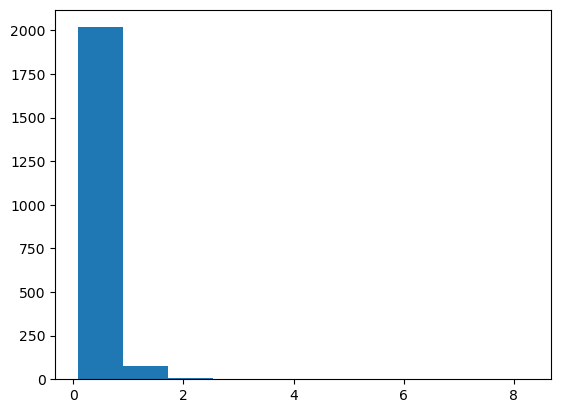

In [14]:
plt.hist(ds_optimising.where((~ds_optimising['coeff for emergence'].isin([np.inf, -np.inf]))*(ds_optimising['coeff for emergence']<10))['coeff for emergence'])#, bins = 20)#[[f't_dev at day {n}' for n in range(200, 300)]]

In [15]:
print(ds_optimising['coeff for emergence'].where(~ds_optimising['coeff for emergence'].isin([np.inf, -np.inf])).dropna().mean(),
      ds_optimising['coeff for flowering'].where(~ds_optimising['coeff for flowering'].isin([np.inf, -np.inf])).dropna().mean(),
      ds_optimising['coeff for ripeness'].where(~ds_optimising['coeff for ripeness'].isin([np.inf, -np.inf])).dropna().mean())

1.008325157733615 0.03658492936480077 0.04598812328016307


In [16]:
print(ds_optimising['coeff for emergence'].where(~ds_optimising['coeff for emergence'].isin([np.inf, -np.inf])).dropna().sample(frac=0.5, replace=False).mean(),
      ds_optimising['coeff for flowering'].where(~ds_optimising['coeff for flowering'].isin([np.inf, -np.inf])).dropna().sample(frac=0.5, replace=False).mean(),
      ds_optimising['coeff for ripeness'].where(~ds_optimising['coeff for ripeness'].isin([np.inf, -np.inf])).dropna().sample(frac=0.5, replace=False).mean())

0.5224664530661277 0.03679363293654118 0.04609247795575865


In [9]:
Maize_set.driver_frame_for_ML.dropna(subset = ['t2m day 0', 'observed time to beginning of flowering'])

,Referenzjahr,Stations_id,t2m day 0,t2m day 1,t2m day 2,t2m day 3,t2m day 4,t2m day 5,t2m day 6,t2m day 7,...,lat,lon,WC SOS,observed time to beginning of flowering,observed time to yellow ripeness,emergence date,index,1,2,3
0,2018,7521.0,8.120025,9.939544,10.950083,14.139244,15.773655,16.335490,11.732658,11.085273,...,54.4333,9.8167,2018-04-15,63.0,108.0,2018-05-16,1168.0,6.0,23.0,26.0
2,2018,7592.0,10.922219,11.834785,12.222355,15.646608,17.160594,18.613257,13.832406,14.057785,...,53.4833,10.6333,2018-04-15,73.0,NaN,2018-05-09,1176.0,5.0,8.0,22.0
4,2018,7623.0,7.296997,8.153608,9.499900,10.779305,13.222063,16.031335,14.912643,10.333736,...,54.6667,9.1333,2018-04-14,57.0,101.0,2018-05-16,1188.0,7.0,25.0,28.0
8,2018,7650.0,9.047308,9.000225,11.001043,14.564890,15.288866,17.350146,12.384319,11.619438,...,54.1000,10.8167,2018-04-15,55.0,NaN,2018-05-15,1203.0,6.0,21.0,25.0
9,2018,7662.0,10.081076,11.064128,11.900764,15.448747,17.400507,17.795941,12.594860,13.485576,...,53.7333,9.7833,2018-04-15,67.0,NaN,2018-05-12,1207.0,5.0,13.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4740,2023,19587.0,8.619230,8.965848,7.935543,5.424142,8.375292,13.165038,12.760963,10.014807,...,48.7091,9.2147,2023-04-17,49.0,123.0,2023-05-27,1157.0,12.0,21.0,33.0
4743,2023,19612.0,8.005281,8.702751,8.217714,6.974363,7.396445,12.911571,15.088900,14.059357,...,52.0507,10.6362,2023-04-16,84.0,121.0,2023-05-18,1160.0,9.0,26.0,35.0
4745,2023,19700.0,5.713335,5.448902,5.580967,11.116664,13.444157,12.497634,9.555045,6.330438,...,50.4316,11.9443,2023-04-18,78.0,132.0,2023-05-19,1163.0,15.0,33.0,36.0
4746,2023,19722.0,4.639520,8.890347,12.034398,11.776999,9.284203,6.104116,6.753432,10.141732,...,47.8655,9.0147,2023-04-20,55.0,109.0,2023-05-21,1164.0,11.0,19.0,33.0


In [3]:
address1 = "C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_akt.txt"
address2 = "C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt"
pd1 = pd.read_csv(address1, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
pd2 = pd.read_csv(address2, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
pd3 = pd.concat([pd1, pd2], axis = 0)
pd3 = pd3.drop('Unnamed: 9', axis = 1)
pd3.drop_duplicates(inplace=True)
pd3.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv')
address3 = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv'
pd4 = pd.read_csv(address3)

In [84]:
phen_data = Maize_set.phen_data
phen_data = phen_data.where(phen_data['Referenzjahr'] > 2016).dropna(how = 'all')
phen_data['Eintrittsdatum'] = pd.to_datetime(phen_data['Eintrittsdatum'], format = '%Y%m%d')
phen_data['Name of phase'].unique()

array(['beginning of flowering', 'beginning of tilling sowing drilling',
       'beginning of emergence', 'beginning of mil ripeness',
       'beginning of wax-ripe stage', 'yellow ripeness', 'harvest',
       'tip of tassel visible', 'beginning of growth in height'],
      dtype=object)

In [85]:
print(np.isin(phen_data['Name of phase'], ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']).shape,
phen_data.shape)

(34674,) (34674, 13)


In [86]:
cond.shape = phen_data.shape

AttributeError: property 'shape' of 'Series' object has no setter

In [87]:
ripeness_data = phen_data.where(phen_data['Name of phase'] == 'yellow ripeness').dropna()
anthesis_data = phen_data.where(phen_data['Name of phase'] == 'beginning of flowering').dropna()
emergence_data = phen_data.where(phen_data['Name of phase'] == 'beginning of emergence').dropna()
cond = phen_data['Name of phase'].isin(['beginning of emergence', 'beginning of flowering', 'yellow ripeness']) #np.isin(phen_data['Name of phase'], ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']).reshape(phen_data.shape[0])
main_stages_data = phen_data.where(cond).dropna()

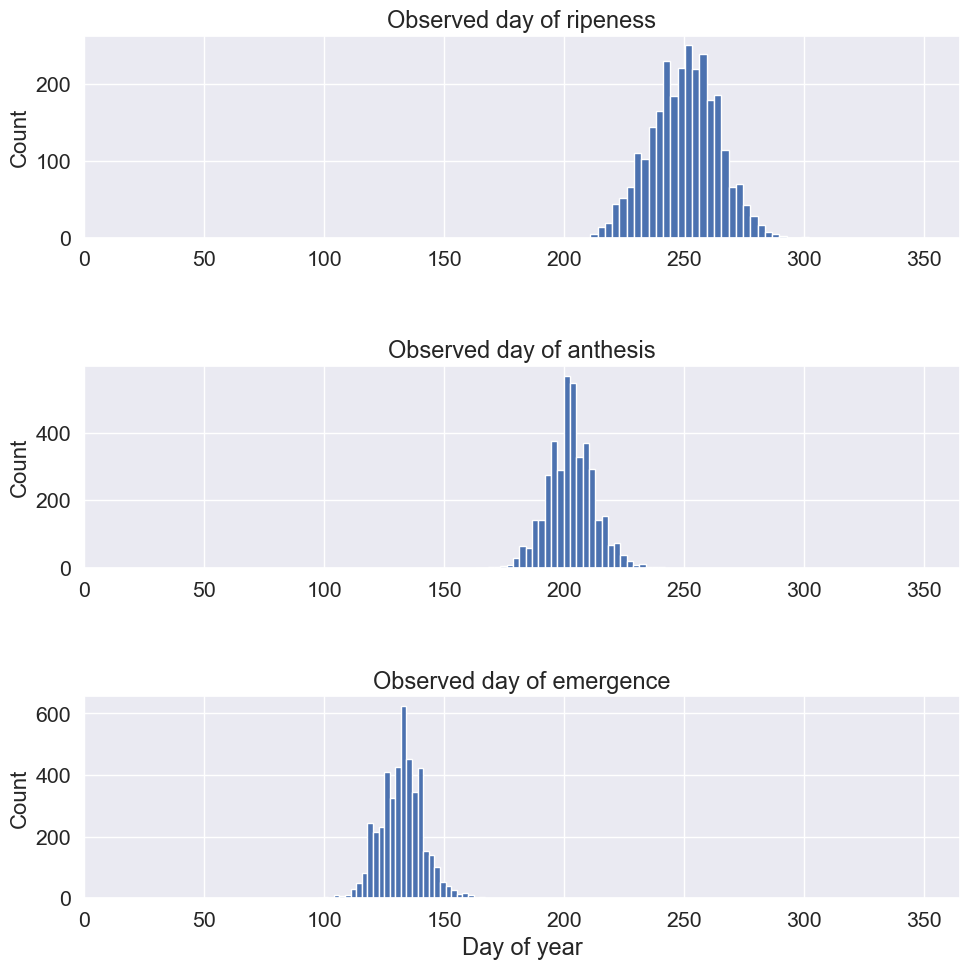

In [88]:
font_size = 17
fig, ax = plt.subplots(3, 1, figsize = (10, 10))

ax[0].hist(ripeness_data['Jultag'], bins = 30)
ax[0].set_xlim([0, 365])
ax[0].set_title('Observed day of ripeness', fontsize = font_size)
#ax[0].set_xlabel('Day of year', fontsize = font_size)
ax[0].set_ylabel('Count', fontsize = font_size - 1)

ax[1].hist(anthesis_data['Jultag'], bins = 30)
ax[1].set_xlim([0, 365])
ax[1].set_title('Observed day of anthesis', fontsize = font_size)
#ax[1].set_xlabel('Day of year', fontsize = font_size)
ax[1].set_ylabel('Count', fontsize = font_size - 1)

ax[2].hist(emergence_data['Jultag'], bins = 30)
ax[2].set_xlim([0, 365])
ax[2].set_title('Observed day of emergence', fontsize = font_size)
ax[2].set_xlabel('Day of year', fontsize = font_size)
ax[2].set_ylabel('Count', fontsize = font_size - 1)

fig.tight_layout(h_pad = 3)
#fig.savefig('plots/avg_num_yearly_obs.png')

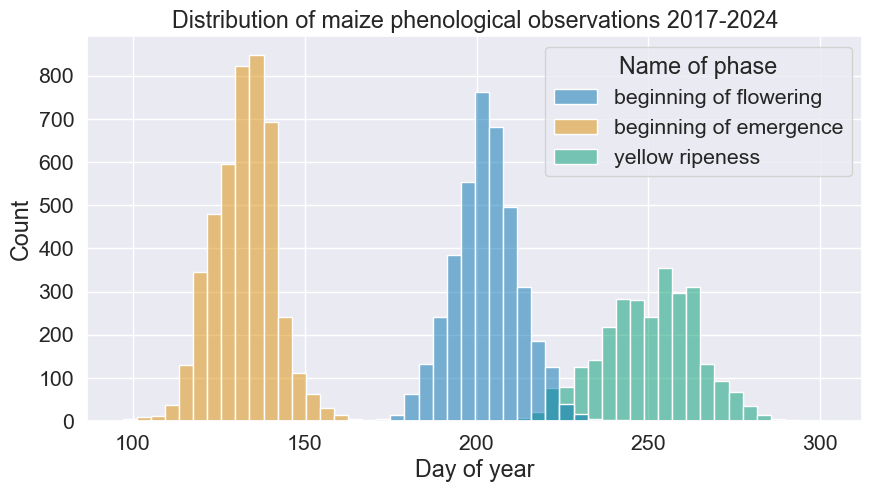

In [89]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.set(font_scale=1.4)
sns.histplot(data=main_stages_data, x="Jultag", hue="Name of phase", bins =50, ax=ax, palette = 'colorblind')
ax.set(xlabel='Day of year', ylabel='Count', title='Distribution of maize phenological observations 2017-2024')
fig.savefig('plots/phenological_obs_distribution.png', bbox_inches='tight')
#ax.tick_params(axis='both', which='major', labelsize=font_size)#axis='x', 
#ax.tick_params(axis='y', labelsize=10)

In [78]:
phase_list2 = ['emergence', 'beginning of flowering', 'yellow ripeness']
thresholds = [0.1, 1, 2]
RMSE_list = []
coord_list = []
Maize_set.get_observed_dataset()
for coeff_1 in np.arange(0.02, 0.09, 0.005):
    for coeff_2 in np.arange(0.02, 0.09, 0.005):
        print([coeff_1, coeff_2])
        resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
        #[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
        Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                                    'tas', thresholds[-1])
        Maize_set.get_phase_dates(thresholds)
        for index, phase in enumerate(phase_list2):
            Maize_set.phase_dates_array = Maize_set.phase_dates_array.rename(columns={str(np.float64(thresholds[index])):f'modelled time to {phase}'})
        Maize_set.phase_dates_array = Maize_set.phase_dates_array.where(Maize_set.phase_dates_array['modelled time to yellow ripeness'] < 200)
        Maize_set.phase_dates_array['modelled time to beginning of flowering'] = Maize_set.phase_dates_array['modelled time to beginning of flowering'] - Maize_set.phase_dates_array['modelled time to emergence']
        Maize_set.phase_dates_array['modelled time to yellow ripeness'] = Maize_set.phase_dates_array['modelled time to yellow ripeness'] - Maize_set.phase_dates_array['modelled time to beginning of flowering']
        ds_comparison = pd.merge(Maize_set.ds_observed, Maize_set.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])
        ds_comparison = ds_comparison.dropna(subset = ['modelled time to beginning of flowering', 'lat', 'lon'])
        ds_comparison = dataset_fctns.add_SOS_to_df(ds_comparison)
        ds_comparison['observed time to emergence'] = pd.to_datetime(ds_comparison['emergence date']).dt.dayofyear - ds_comparison['SOS']
        RMSE_list.append(RMSE_model2(ds_comparison, phase_list2))
        coord_list.append([coeff_1, coeff_2])



[0.02, 0.02]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 105. 105. 105.]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, 'SOS'] = WC_SOS(df['lon'], df['lat'])
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.025]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.030000000000000002]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.035]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.04000000000000001]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.045000000000000005]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


KeyboardInterrupt: 

In [ ]:
phase_dates_array
        ds_comparison = pd.merge(Maize_set.ds_observed, Maize_set.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])
        ds_comparison = ds_comparison.dropna(subset = ['modelled time to beginning of flowering', 'lat', 'lon'])
        ds_comparison = dataset_fctns.add_SOS_to_df(ds_comparison)
        ds_comparison['observed time to emergence'] = pd.to_datetime(ds_comparison['emergence date']).dt.dayofyear - ds_comparison['SOS']
        RMSE_list.append(RMSE_model2(ds_comparison, phase_list2))
        coord_list.append([coeff_1, coeff_2])

In [22]:
print(coord_list[np.linalg.norm(np.array(RMSE_list), axis = 1).argmin()],
      RMSE_list[np.linalg.norm(np.array(RMSE_list), axis = 1).argmin()])

[0.02, 0.02] [nan, nan, nan]


In [23]:
RMSE_list#[np.linalg.norm(np.array(RMSE_list), axis = 1).argmin()]

[[nan, nan, nan],
 [7.220660013771785, 15.393684329665179, 22.578517969171727],
 [8.791872934874018, 16.616525235171434, 29.05142866102073],
 [9.572624255403277, 17.764039123263906, 31.080074235637753],
 [11.187302521381909, 18.282936127019028, 32.09855081285936],
 [12.233118419143224, 18.813491535813228, 34.64408702733335],
 [12.774953394401766, 18.90333754162915, 36.2741655335881],
 [12.883372483542793, 19.395404393982, 37.906292739975285],
 [13.161561185365278, 20.191577529990226, 38.4126778660503],
 [13.817727792842145, 20.463755914358657, 39.08831733042672],
 [14.161385272166976, 20.722957676613575, 39.66489496034962],
 [14.518529049974275, 20.8833810202486, 40.931196772123734],
 [14.745794533374333, 21.128953279011874, 41.75056035094004],
 [15.067820535375198, 21.209035666817805, 42.87106138028109],
 [6.635761699558938, 9.311283477587825, 19.616051429485257],
 [8.180915248410534, 11.43029681999809, 25.134421227368307],
 [10.056459759381381, 12.562090687818632, 27.82148307755934],

In [25]:
ds_comparison#.dropna(subset = ['modelled time to beginning of flowering'])

,Referenzjahr,Stations_id,observed time emergence to beginning of flowering,observed time emergence to yellow ripeness,lat,lon,emergence date,modelled time to emergence,modelled time to beginning of flowering,modelled time to yellow ripeness
0,1951.0,7617.0,29.0,NaN,54.6167,9.0333,NaT,NaN,NaN,NaN
1,1951.0,7899.0,80.0,NaN,52.0833,9.5667,NaT,NaN,NaN,NaN
2,1951.0,8137.0,50.0,NaN,52.8667,9.6000,NaT,NaN,NaN,NaN
3,1951.0,8191.0,54.0,NaN,53.2667,10.1167,NaT,NaN,NaN,NaN
4,1951.0,8234.0,98.0,NaN,52.9333,11.1167,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
28902,2023.0,19612.0,84.0,121.0,52.0507,10.6362,2023-05-18,38.0,76.0,114.0
28903,2023.0,19700.0,78.0,132.0,50.4316,11.9443,2023-05-19,49.0,85.0,128.0
28904,2023.0,19722.0,55.0,109.0,47.8655,9.0147,2023-05-21,38.0,71.0,107.0
28905,2023.0,19770.0,NaN,NaN,NaN,NaN,2023-05-20,36.0,74.0,113.0


In [24]:
dataset_fctns.add_SOS_to_df(ds_comparison.dropna(subset = ['modelled time to beginning of flowering', 'lat', 'lon']))

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SOS'] = WC_SOS(df['lon'], df['lat'])


,Referenzjahr,Stations_id,observed time emergence to beginning of flowering,observed time emergence to yellow ripeness,lat,lon,emergence date,modelled time to emergence,modelled time to beginning of flowering,modelled time to yellow ripeness,SOS
24456,2017.0,7532.0,80.0,134.0,54.4000,8.7667,2017-05-14,45.0,98.0,162.0,103.0
24457,2017.0,7564.0,80.0,128.0,54.7167,9.9500,2017-05-10,44.0,101.0,183.0,104.0
24458,2017.0,7564.0,80.0,128.0,54.7167,9.9500,2017-05-10,35.0,81.0,113.0,104.0
24459,2017.0,7592.0,76.0,NaN,53.4833,10.6333,2017-05-19,40.0,84.0,135.0,104.0
24461,2017.0,7616.0,76.0,139.0,54.6167,8.9667,2017-05-14,46.0,103.0,187.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...
28900,2023.0,19587.0,49.0,123.0,48.7091,9.2147,2023-05-27,36.0,67.0,94.0,106.0
28902,2023.0,19612.0,84.0,121.0,52.0507,10.6362,2023-05-18,38.0,76.0,114.0,105.0
28903,2023.0,19700.0,78.0,132.0,50.4316,11.9443,2023-05-19,49.0,85.0,128.0,107.0
28904,2023.0,19722.0,55.0,109.0,47.8655,9.0147,2023-05-21,38.0,71.0,107.0,109.0


In [55]:
Maize_set.phase_dates_array

,1,2,3,Referenzjahr,Stations_id
0,26.0,29.0,115.0,2022,7521.0
1,24.0,26.0,108.0,2023,7521.0
2,26.0,28.0,114.0,2022,7532.0
3,18.0,26.0,88.0,2023,7532.0
4,23.0,26.0,65.0,2022,7592.0
...,...,...,...,...,...
4443,6.0,9.0,104.0,2019,19727.0
4444,20.0,22.0,77.0,2017,19731.0
4445,26.0,28.0,64.0,2017,19914.0
4446,3.0,4.0,23.0,2018,19914.0


In [138]:
ds = Maize_set.driver_frame_for_ML['modelled time to emergence'] + pd.to_datetime(Maize_set.driver_frame_for_ML['WC SOS']).dt.dayofyear
ds = ds.where(ds < 200)
plt.hist(ds.dropna(), bins = 20)

KeyError: 'modelled time to emergence'

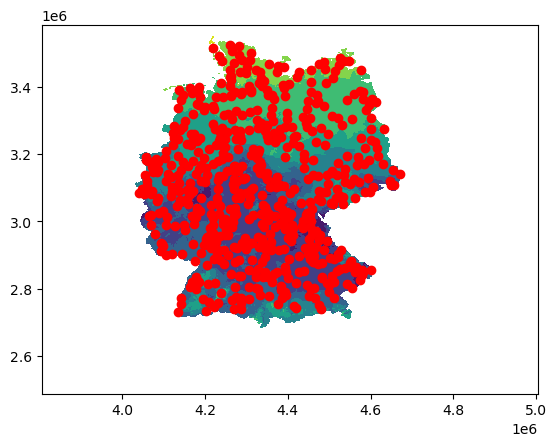

In [11]:
fig, axs = plt.subplots()
axs.contourf(Maize_set.T_mean['x'], Maize_set.T_mean['y'], Maize_set.T_mean['tas'].isel(time = 0).values)
for index, x in enumerate(Maize_set.x_epsg):
    axs.plot(x, Maize_set.y_epsg[index], 'ro')

In [104]:
## Functions for ML ##    
def put_obs_data_in_input_array(self): #, predictor_days = 200
    y_data = {}
    for phase_time in self.ds_observed.columns:
        if phase_time != 'lat' and phase_time != 'lon':
            y_data[phase_time] = (['modelpoint'], self.ds_observed[phase_time].values)
    #print(y_data)
    obs_data = xr.Dataset(data_vars = y_data,
                            coords = {'Referenzjahr':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(0))),
                                    'Stations_id':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(1)))}
                                    )
    #print(obs_data)
    obs_data = obs_data.set_xindex(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = self.GDD_driver_data.reset_index('modelpoint')
    #self.GDD_driver_data['Stations_id'] = self.GDD_driver_data['Stations_id'].astype(np.int64)
    #self.GDD_driver_data['Referenzjahr'] = self.GDD_driver_data['Referenzjahr'].astype(np.int64)
    self.GDD_driver_data = self.GDD_driver_data.set_coords(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_coords(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_xindex(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = xr.merge([self.GDD_driver_data, obs_data], join='left') #self.data_for_ML = xr.merge([self.data_for_ML, obs_data], join='left')#[driver_variable]
    self.GDD_driver_data = self.GDD_driver_data.dropna('modelpoint') #self.data_for_ML = self.data_for_ML.dropna('modelpoint')


In [89]:
def get_X_y_for_ML(self, driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2020, end_year = 2023):
    self.just_emergence = dataset_fctns.add_EOS_to_df(self.just_emergence)
    self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
    self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
    self.just_emergence['SOS'] = pd.to_timedelta(self.just_emergence['SOS'], 'D')
    time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'SOS']].drop_duplicates()) #, 'Referenzjahr'
    time_station = time_station.set_coords('Stations_id').set_xindex(['Stations_id'])
    time_station = time_station.drop_vars('index')
    time_station = time_station.expand_dims(dim={'time':pd.to_timedelta(np.arange(0, predictor_days), 'D')})
    time_station = time_station.expand_dims(dim={'Referenzjahr':pd.date_range(f'{start_year}-01-01', periods = end_year - start_year, freq='YS')})
    time_station['SOS'] = time_station['SOS'] + time_station['Referenzjahr'] + time_station['time'] + pd.Timedelta(12, 'h')
    time_station = time_station.rename({'time':'time_from_SOS', 'SOS':'time'})
    time_station = time_station.reset_index('Stations_id').reset_coords(names = 'Stations_id')
    self.time_station = time_station
    self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
    self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
    self.driver_data_for_ML = self.driver_data_for_ML.set_xindex(['Stations_id'])
    self.driver_data_for_ML['Referenzjahr'] = pd.to_datetime(self.driver_data_for_ML['Referenzjahr']).year
    self.driver_frame_for_ML = self.driver_data_for_ML.to_dataframe(dim_order = ['Referenzjahr', 'Stations_id', 'time_from_SOS'])
    self.driver_frame_for_ML = pd.concat([self.driver_frame_for_ML['tas'].unstack(),
                                          self.driver_frame_for_ML['lat'].unstack()['0 days'].rename('lat'),
                                          self.driver_frame_for_ML['lon'].unstack()['0 days'].rename('lon'),
                                          self.driver_frame_for_ML['time'].unstack()['0 days'].rename('WC SOS')], axis=1)
    self.driver_frame_for_ML.rename(columns={self.driver_frame_for_ML.columns[x]: f'{driver_variable} day {x}' for x in range(200)}, inplace=True)
    self.driver_frame_for_ML = pd.merge(hmm.driver_frame_for_ML.reset_index(), hmm.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)
    #self.X_for_ML = self.driver_data_for_ML[:predictor_days, :].values.T
    #if cumulative:
    #    self.X_for_ML = np.cumsum(self.X_for_ML, axis=1)
    #if thinning_parameter != 1:
    #    self.X_for_ML = self.X_for_ML[:, ::thinning_parameter]
    #self.y_for_ML = np.array([self.GDD_driver_data[phase_time].values for phase_time in self.ds_observed.columns[:-2]])[:predictor_days, :].T
    #for station in self.just_emergence['Stations_id'].unique():
    #    just_station = self.just_emergence.where(self.just_emergence['Stations_id'] == station).dropna()
    #    for year in just_station['Referenzjahr'].unique():
    #        just_station_year = just_station.where(just_station['Referenzjahr'] == year).dropna()
    #        print(just_station_year)
    #        station_data = self.GDD_driver_data.sel({'Stations_id':station})
    #        #, time = slice(just_station_year['WC SOS date'].values[0] + pd.Timedelta(12, 'h'), just_station_year['WC SOS date'].values[0] + pd.Timedelta(12, 'h') + pd.Timedelta(predictor_days, 'D')))
    #        print(station_data)
    return self

In [ ]:
hmm = get_X_y_for_ML(Maize_set, start_year = 2022, end_year=2025)

In [ ]:
pd.merge(hmm.driver_frame_for_ML.reset_index(), hmm.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)

In [ ]:
pd.concat([hmm.driver_frame_for_ML, hmm.ds_observed.set_index(['Referenzjahr', 'Stations_id'])], axis=1, )
hmm.driver_frame_for_ML.join(hmm.ds_observed.set_index(['Referenzjahr', 'Stations_id']), how='left')

In [ ]:
hmm.driver_frame_for_ML.index.get_level_values(0) = hmm.driver_frame_for_ML.index.get_level_values(0).year#['Referenzjahr']

In [73]:
obs = xr.Dataset.from_dataframe(hmm.ds_observed)
obs = obs.reset_index('index')
obs = obs.assign_coords({'Stations_id':obs['Stations_id'],'Referenzjahr':obs['Referenzjahr']})
obs = obs.set_xindex(['Stations_id', 'Referenzjahr'])

In [5]:
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)


<xarray.Dataset> Size: 14kB
Dimensions:                (Emergence observation: 600)
Coordinates:
  * Emergence observation  (Emergence observation) int64 5kB 448 983 ... 411726
Data variables:
    Stations_id            (Emergence observation) float64 5kB 7.521e+03 ... ...
    time                   (Emergence observation) datetime64[ns] 5kB 2022-05...


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_7620\3188619908.py:113: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  t_dev = np.zeros(time_station.dims['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.


ValueError: those coordinates already have an index: {'Stations_id'}

In [ ]:
Maize_set.compare_modelled_observed()

In [36]:
observed_dataset.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')

In [2]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array()
tp=3
resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
thresholds = [1, 2]
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.phase_list = ['beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.get_modelled_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.put_obs_data_in_input_array()
Maize_set.compare_modelled_observed()
Maize_set.get_X_y_for_ML('tas', cumulative=True, thinning_parameter=tp)
Maize_set.subsample_X_y(subsample_frac=0.8)
Maize_set.decision_tree(md=3)#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.ML_modelled_observed()

In [16]:
# data rows of csv file
coords = Maize_set.phen_data[['lat', 'lon', 'Stations_id']].drop_duplicates().values
# using the savetxt
# from the numpy module
np.savetxt("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\station_coords.csv",
        coords,
        delimiter =", ",
        fmt ='% s')

In [12]:
phase_list = ['beginning of flowering', 'yellow ripeness']
training_means = []
for phase in phase_list:
    training_means.append(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].mean())
    print(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].count())
RMSE_ML_model(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)
#plot_error_distn(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)

9872
9872
Phase: beginning of flowering
RMSE for ML is 10.2
RMSE for model is 14.2
RMSE to training mean is 10.2
Phase: yellow ripeness
RMSE for ML is 15.3
RMSE for model is 27.5
RMSE to training mean is 13.7


In [ ]:
phase_list = ['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness']#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness', 'harvest']
#Maize_set.get_observed_dataset(phase_list=phase_list)
plotting.plot_obs_per_year(Maize_set.ds_observed, 'obs_per_year', phase_list=phase_list)
plotting.hist2d_locations(Maize_set.ds_observed.loc[2020].dropna()['lat'], Maize_set.ds_observed.loc[2020].dropna()['lon'], bin_num=5)
plotting.box_plot_modelled_observed(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), ['beginning of flowering', 'yellow ripeness'])

In [ ]:
tree_rules = tree.export_text(Maize_set.regr, feature_names=[f'Day {tp*i} cum. temp' for i in range(np.int64(np.floor(200/tp)))])
print(Maize_set.y_for_ML)
print(tree_rules)